# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import random
from matplotlib import pyplot as plt
from collections import deque
import copy
import time
import utils as ut

# Check that current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# Check that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
False


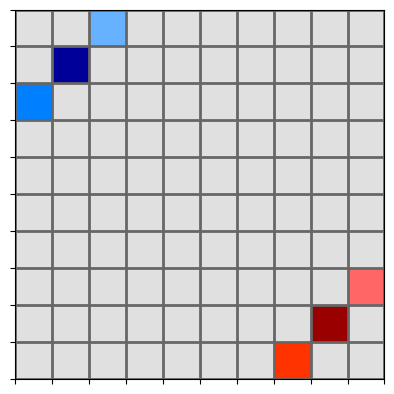

In [2]:
# instantiate environment
env = GridworldCtf(game_mode='random')
env.render()

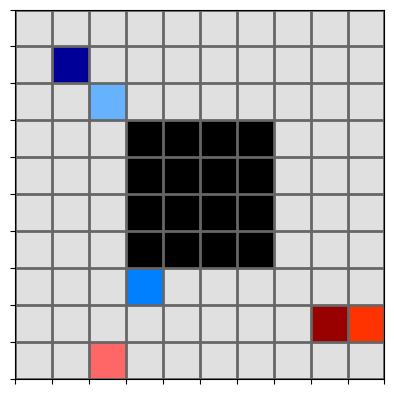

You win!, total score 152


In [3]:
# example against random agents
env.play()

## Deep Q-Network

### Train agents

In [2]:
# create environment
env = GridworldCtf(game_mode='static')
device = "cpu"

# configure agents
batch_size = 32
gamma = 0.9
lr = 0.000025
epsilon = 1.0
target_update_steps = 1000
mem_size = 40000
n_actions = 4
use_softmax = True

agent_t1 = DQNAgent(q_network=DQNNetwork(name='dqn_t1', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax)

agent_t2 = DQNAgent(q_network=DQNNetwork(name='dqn_t2', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax)

# train agents
env_dims = (1, 1, 10, 10)
epochs = 2000
epsilon_decay = 0.999
epsilon_min = 0.1
losses = []
score_history = []
n_random_steps = 2000
max_steps = 1000
learning_skip_steps = 1
step_count = 0
done_count = 0
team_1_captures = []
team_2_captures = []
episode_step_counts = []

for i in range(epochs):
    env.reset()

    curr_grid_state_ = env.grid.reshape(*env_dims) + ut.add_noise(env_dims)
    curr_grid_state = torch.from_numpy(curr_grid_state_).float().to(device)

    done = False
    episode_step_count = 0
    score = 0
    while not done: 
        step_count += 1
        episode_step_count += 1

        # collect actions for each agent
        actions =[]
        for agent_idx in np.arange(4):
            curr_metadata_state = ut.get_env_metadata(agent_idx, env.has_flag, device=device)
            if env.AGENT_TEAMS[agent_idx]==0:
                actions.append(agent_t1.choose_action(curr_grid_state, curr_metadata_state))
            else:
                actions.append(agent_t2.choose_action(curr_grid_state, curr_metadata_state))

        # step the environment
        new_grid_state, rewards, done = env.step(actions)
        new_grid_state_ = new_grid_state.reshape(*env_dims) + ut.add_noise(env_dims)
        new_grid_state = torch.from_numpy(new_grid_state_).float().to(device)

        # increment score
        score += sum(rewards)

        # store each agent experiences
        for agent_idx in np.arange(4):
            new_metadata_state = ut.get_env_metadata(agent_idx, env.has_flag, device=device)

            # append replay buffer
            if env.AGENT_TEAMS[agent_idx]==0:
                agent_t1.memory.append(
                                    ((curr_grid_state, curr_metadata_state), 
                                    actions[agent_idx], 
                                    rewards[agent_idx], 
                                    (new_grid_state, new_metadata_state), 
                                    done)
                                    )
            else:
                agent_t2.memory.append(
                                    ((curr_grid_state, curr_metadata_state), 
                                    actions[agent_idx], 
                                    rewards[agent_idx], 
                                    (new_grid_state, new_metadata_state), 
                                    done)
                                    )

        curr_grid_state = new_grid_state
        
        # learning
        if step_count%learning_skip_steps==0 and min(len(agent_t1.memory), len(agent_t2.memory)) > batch_size:
            loss_t1 = agent_t1.update_network(step_count)
            loss_t2 = agent_t2.update_network(step_count)
        else:
            loss_t1 = 0.0
            loss_t2 = 0.0

        # append metrics
        losses.append((loss_t1, loss_t2))  

        # termination
        if done or episode_step_count > max_steps:
            team_1_captures.append(env.team_points[0])
            team_2_captures.append(env.team_points[1])
            done_count += 1 * done
            done = True
            
    # decay epsilon
    epsilon_ = max(epsilon * epsilon_decay**i, epsilon_min)
    agent_t1.epsilon = epsilon_
    agent_t2.epsilon = epsilon_

    score_history.append(score)
    episode_step_counts.append(episode_step_count)

    if i % 5 == 0:
        clear_output(wait=True)
        print(f'episode: {i} \ntotal step count: {step_count} \nepisode step count: {episode_step_count} \
              \nscore: {score} \naverage score: {np.mean(score_history[-100:])} \
              \nepsilon: {round(epsilon_, 4)} \ndone count: {done_count} \
              \nteam 1 captures: {sum(team_1_captures)} \nteam 2 captures: {sum(team_2_captures)}')


# save models
agent_t1.save_model()
agent_t2.save_model()

episode: 1995 
total step count: 231579 
episode step count: 79               
score: -13 
average score: 9.26               
epsilon: 0.1359 
done count: 1990               
team 1 captures: 270 
team 2 captures: 5924


#### Performance metrics

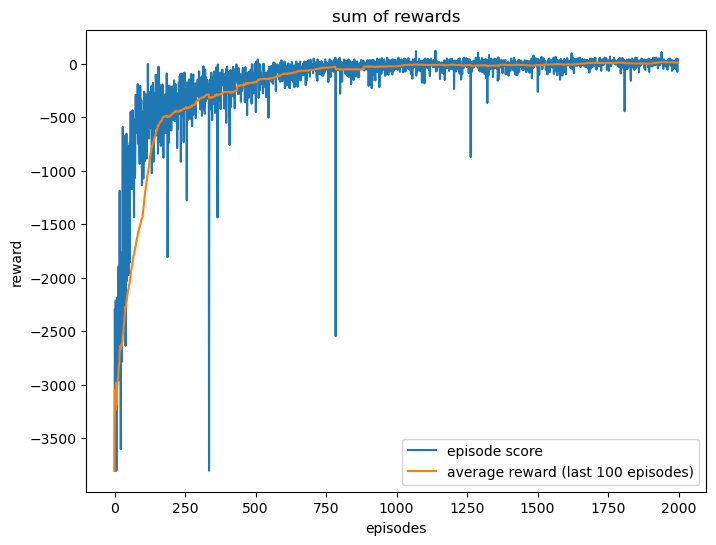

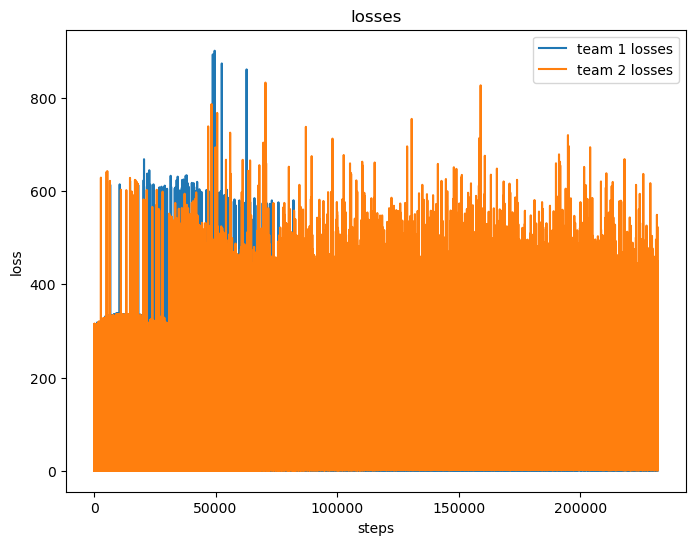

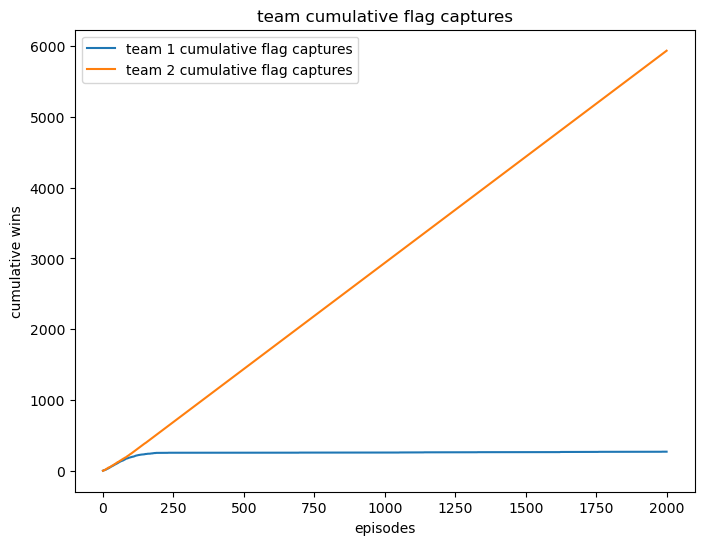

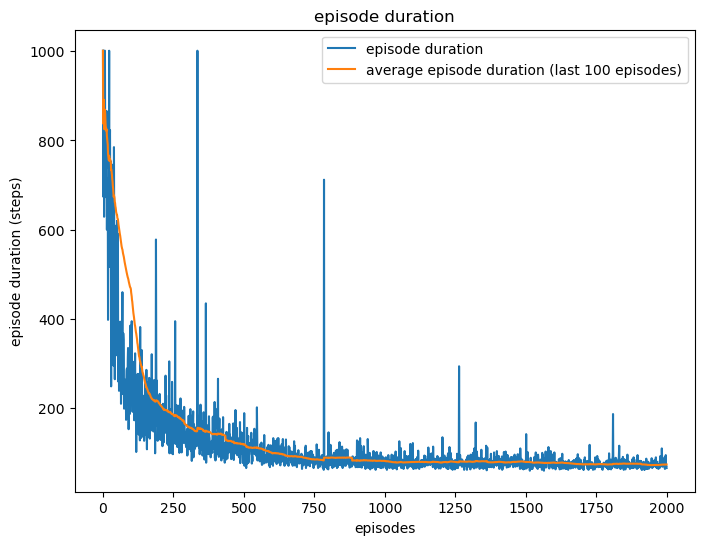

In [3]:
# plot rewards
plt.figure(figsize=(8, 6))
plt.title('sum of rewards')
plt.plot(score_history, label='episode score')
plt.plot([np.mean(score_history[::-1][i:i+100]) for i in range(len(score_history))][::-1], label='average reward (last 100 episodes)')
plt.xlabel("episodes")
plt.ylabel("reward")
plt.legend()
plt.show()

# plot losses
plt.figure(figsize=(8, 6))
plt.title('losses')
plt.plot([l[0] for l in losses], label='team 1 losses')
plt.plot([l[1] for l in losses], label='team 2 losses')
plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.show()

# plot team cumulative wins
plt.figure(figsize=(8, 6))
plt.title('team cumulative flag captures')
plt.plot(np.cumsum(team_1_captures), label='team 1 cumulative flag captures')
plt.plot(np.cumsum(team_2_captures), label='team 2 cumulative flag captures')
plt.xlabel("episodes")
plt.ylabel("cumulative wins")
plt.legend()
plt.show()

# plot rewards
plt.figure(figsize=(8, 6))
plt.title('episode duration')
plt.plot(episode_step_counts, label='episode duration')
plt.plot([np.mean(episode_step_counts[::-1][i:i+100]) for i in range(len(score_history))][::-1], label='average episode duration (last 100 episodes)')
plt.xlabel("episodes")
plt.ylabel("episode duration (steps)")
plt.legend()
plt.show()

#### Inference

In [ ]:
# load saved network weights
dqn_t1 = DQNNetwork(name='dqn_t1')
dqn_t1.load_model()

dqn_t2 = DQNNetwork(name='dqn_t2')
dqn_t2.load_model()

# create agents
use_softmax = True
agent_t1 = DQNAgent(q_network=dqn_t1 ,
                    use_softmax=use_softmax)

agent_t2 = DQNAgent(q_network=dqn_t2,
                    use_softmax=use_softmax)

# create environment
env = GridworldCtf()           
env_dims = (1, 1, 10, 10)

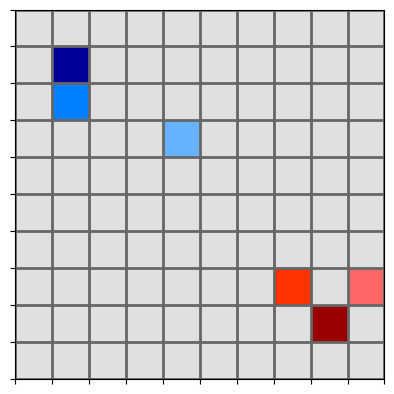

Game won!                       
Final score: -9                       
Team 1 score: 0                       
Team 2 score: 3                       
Total moves: 78


In [4]:
env_dims = (1, 1, 10, 10)

# test model
ut.test_model(env, agent_t1, agent_t2, env_dims, display=True, max_moves=200)

#### Interactive play with trained agents

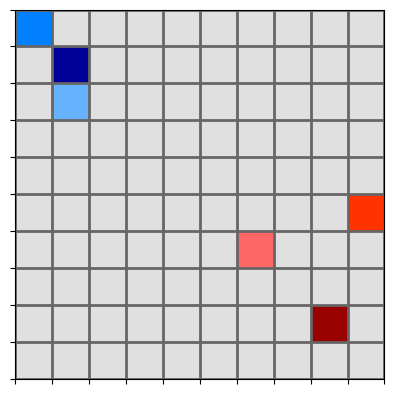

You win!, total score 238


In [5]:
env = GridworldCtf(game_mode='static')
env.play(player=0, agents=[agent_t1, agent_t2])